In [1]:
import numpy
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from costmap import CostMap

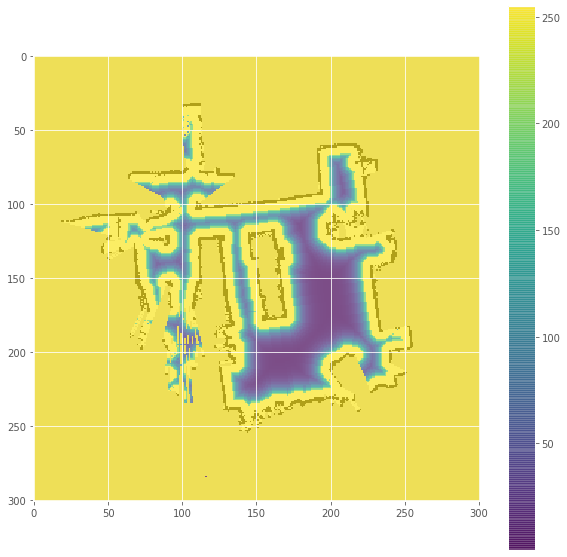

In [14]:
cm=CostMap("maps/test_map.pgm")

plt.figure(figsize=(10,10))
plt.imshow(cm.occmap_arr[100:401,100:401],plt.cm.binary)
plt.imshow(cm.costmap_arr[100:401,100:401],alpha=0.7)
plt.colorbar()
plt.show()

## Costmap to Weighted Graph

In [3]:
class Graph:
    
    #Nodes
    def __init__(self):
        self.all_nodes=[]
    
    #Edges
    def neighbors(self,node):
        dirs = [[1, 0],
                [0, 1],
                [-1, 0],
                [0, -1],
                [-1, -1],
                [-1, 1],
                [1, -1],
                [1, 1]]
#         dirs = [[1, 0], [0, 1], [-1, 0], [0, -1]]
        result = []
        for dir in dirs:
            neighbor = (node[0] + dir[0], node[1] + dir[1])
            if neighbor in self.all_nodes:
                result.append(neighbor)

        return result

class WeightedGraph(Graph):
   
    def __init__(self):
        super().__init__()
        self.weights = {}
    
    #Edges Costs
    def cost(self, from_node, to_node):
        return self.weights.get(to_node, 255)
    
all_nodes=[]
cell_costs={}
for x in range(cm.costmap_arr.shape[0]):
    for y in range(cm.costmap_arr.shape[1]):
        if cm.costmap_arr[x,y] < cm.INSCRIBED_INFLATED_OBSTACLE:
            all_nodes.append((x,y))
            cell_costs[(x,y)]=cm.costmap_arr[x,y]

graph=WeightedGraph()
graph.all_nodes=all_nodes
graph.weights=cell_costs

## Dijkstra Algorithm

In [4]:
import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]

In [5]:
%%time
def dijkstra_search(graph, start, goal):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == goal:
            break
        
        for next in graph.neighbors(current):
            new_cost = cost_so_far[current] + graph.cost(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost
                frontier.put(next, priority)
                came_from[next] = current
    
    return came_from, cost_so_far

res,costs = dijkstra_search(graph,(300,300), (200, 200));

CPU times: user 9.96 s, sys: 0 ns, total: 9.96 s
Wall time: 9.95 s


### PATH

In [6]:
def reconstruct_path(start,goal,came_from):
    """
    """
    current = goal 
    path = []
    while current != start: 
        path.append(current)
        current = came_from[current]
    path.append(start) # optional
    path.reverse() # optional
    return path

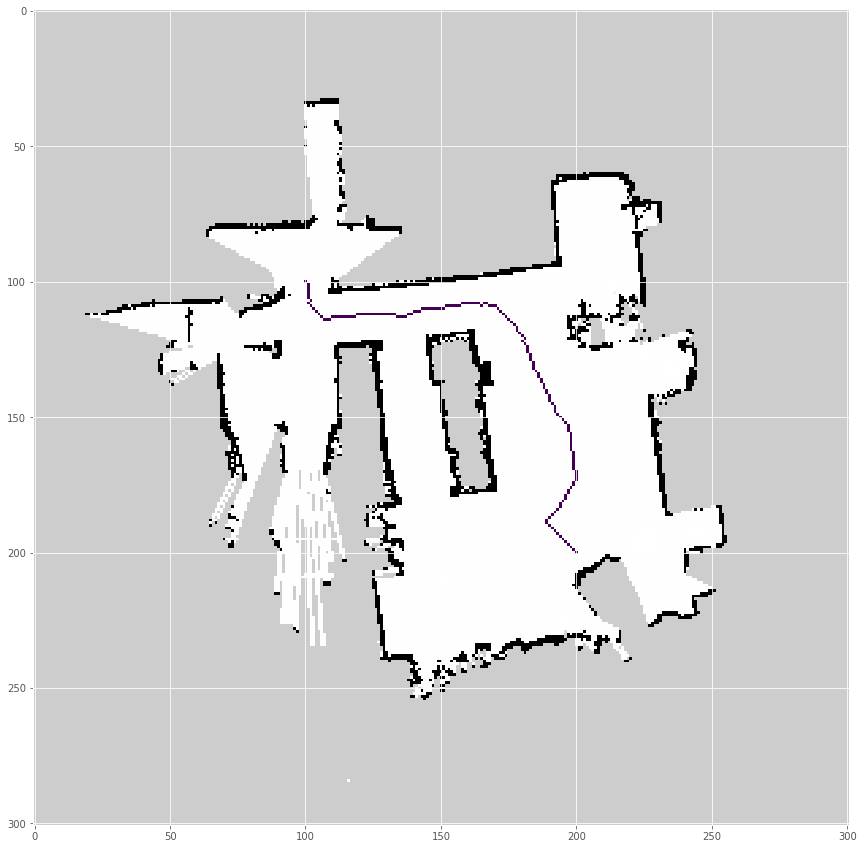

In [10]:
path_overlay=numpy.zeros_like(cm.costmap_arr)
for step in reconstruct_path((300,300), (200, 200),res):
    path_overlay[step[0],step[1]]=1

path_overlay_mask = numpy.ma.masked_where(path_overlay == 0, path_overlay)     

plt.figure(figsize=(15,15))
plt.imshow(cm.occmap_arr[100:401,100:401],plt.cm.binary)
plt.imshow(path_overlay_mask[100:401,100:401])
#plt.colorbar()
plt.show()

### Computed Path Cost

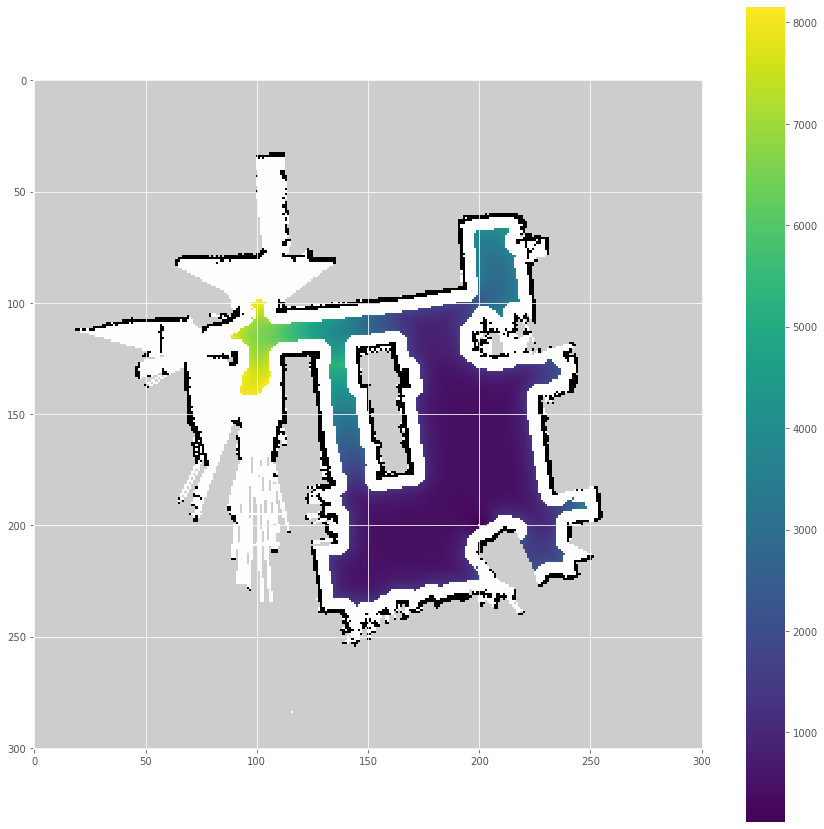

In [11]:
cost_overlay=numpy.zeros_like(cm.costmap_arr)
for key, value in costs.items():
    cost_overlay[key[0],key[1]]=value

cost_overlay_mask = numpy.ma.masked_where(cost_overlay == 0, cost_overlay)     

plt.figure(figsize=(15,15))
plt.imshow(cm.occmap_arr[100:401,100:401],plt.cm.binary)
plt.imshow(cost_overlay_mask[100:401,100:401])
plt.colorbar()
plt.show()